In [1]:
!pip install segmentation-models-pytorch albumentations
!pip install wandb

In [2]:
# =========================
# 0. 기본 설정 및 라이브러리 임포트
# =========================
import os
import glob
import cv2
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GroupKFold
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from tqdm import tqdm
import wandb

os.environ["WANDB_API_KEY"] = "606f273cf9d1d864ce1e44e2ec1cbebef36d71c8"
wandb.login()

# Configuration & Path Setup
CONFIG = {
    'ROOT_DIR': '/data/ephemeral/home/data',
    'IMAGE_SIZE': 1024,
    'BATCH_SIZE': 4,
    'LR': 1e-4,
    'EPOCHS': 30,
    'SEED': 42,
    'NUM_CLASSES': 29,
    'PROJECT_NAME': 'SMP U-Net + EfficientNet',
    'RUN_NAME': 'UNet++_B4_Slide'
}

# 클래스 정의 (총 29개)
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19',
    'Trapezium', 'Trapezoid', 'Capitate', 'Hamate',
    'Scaphoid', 'Lunate', 'Triquetrum', 'Pisiform', 'Radius', 'Ulna'
]
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}

/data/ephemeral/home/py310/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
wandb: Currently logged in as: yujh5537 (cv_12) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
# =========================
# 1. Data Parsing
# =========================
def get_data_paths(root_dir):
    """
    IDXXX 폴더 내의 모든 png 파일을 찾고, 
    그에 매핑되는 json 파일 경로와 그룹 ID를 생성합니다.
    """
    # 1. Train Image Paths 가져오기 (Recursive)
    # 예: /data/ephemeral/home/data/train/DCM/ID001/image.png
    search_path = os.path.join(root_dir, 'train/DCM', '**', '*.png')
    png_paths = glob.glob(search_path, recursive=True)
    png_paths = sorted(png_paths) # 정렬 보장
    
    json_paths = []
    groups = []
    
    for png_path in png_paths:
        # 2. JSON 경로 생성
        # 문자열 치환: DCM -> outputs_json, .png -> .json
        # 주의: 경로 중간의 폴더명만 정확히 바뀌어야 함
        json_path = png_path.replace('/DCM/', '/outputs_json/').replace('.png', '.json')
        json_paths.append(json_path)
        
        # 3. Group ID 추출 (폴더명 IDXXX)
        # 경로 예시: .../train/DCM/ID001/image.png -> parent folder는 ID001
        parent_folder = os.path.dirname(png_path)
        group_id = os.path.basename(parent_folder) # ID001 추출
        groups.append(group_id)
        
    return png_paths, json_paths, groups

# 데이터 경로 로드 실행
train_pngs, train_jsons, groups = get_data_paths(CONFIG['ROOT_DIR'])
print(f"Total Train Images: {len(train_pngs)}")
print(f"Example Image Path: {train_pngs[0]}")
print(f"Example Label Path: {train_jsons[0]}")
print(f"Example Group ID:   {groups[0]}")

Total Train Images: 800
Example Image Path: /data/ephemeral/home/data/train/DCM/ID001/image1661130828152_R.png
Example Label Path: /data/ephemeral/home/data/train/outputs_json/ID001/image1661130828152_R.json
Example Group ID:   ID001


In [4]:
# =========================
# 2. Dataset Class definition
# =========================
class XRayDataset(Dataset):
    def __init__(self, image_paths, label_paths, transforms=None):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, item):
        # 1. 이미지 로드
        image_path = self.image_paths[item]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 2. 라벨(Mask) 생성
        label_path = self.label_paths[item]
        # (H, W, Class) 형태의 마스크 생성
        mask = np.zeros((image.shape[0], image.shape[1], CONFIG['NUM_CLASSES']), dtype=np.uint8)
        
        # JSON 파일이 존재하는지 확인 (방어 코드)
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                annotations = json.load(f)["annotations"]
                
            for ann in annotations:
                c_name = ann["label"]
                if c_name in CLASS2IND:
                    c_ind = CLASS2IND[c_name]
                    points = np.array(ann["points"])
                    
                    # 해당 클래스 채널에 다각형 그리기 (1로 채움)
                    class_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
                    cv2.fillPoly(class_mask, [points], 1)
                    
                    # 기존 마스크에 덮어쓰거나 더하기 (Maximum)
                    mask[..., c_ind] = np.maximum(mask[..., c_ind], class_mask)

        # 3. Augmentation 적용 (Resize 등)
        if self.transforms:
            augmented = self.transforms(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask'] # (29, H, W) 형태로 변환됨 (ToTensorV2 덕분)
            
        # 4. Channel First 변환 (H, W, C) -> (C, H, W)는 ToTensorV2가 처리
        if mask.ndim == 3 and mask.shape[-1] == CONFIG['NUM_CLASSES']:
            mask = mask.permute(2, 0, 1)
            
        return image, mask.float()

# Stronger Augmentation
train_transform = A.Compose([
    # 1. 크기 및 비율 변환 (RandomResizedCrop이 일반화에 더 좋음)
    A.RandomResizedCrop(
        height=CONFIG['IMAGE_SIZE'], width=CONFIG['IMAGE_SIZE'], 
        scale=(0.5, 1.0), ratio=(0.75, 1.33), p=1.0
    ),
    
    # 2. 기하학적 변환 (손 뼈의 다양한 포즈 대응)
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
    
    # 3. [핵심] 의료 영상 특화 변환 (왜곡)
    A.OneOf([
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=1.0),
        A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0),
    ], p=0.5),
    
    # 4. 화질 및 대비 변환 (X-ray 명암 대응)
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    
    # 5. 노이즈 추가 (강인함 증가)
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    
    A.Normalize(),
    ToTensorV2()
])

# Valid는 기존처럼 CenterCrop 유지 (또는 Resize로 변경 가능)
valid_transform = A.Compose([
    A.CenterCrop(height=CONFIG['IMAGE_SIZE'], width=CONFIG['IMAGE_SIZE']),
    A.Normalize(),
    ToTensorV2()
])


/tmp/ipykernel_1789758/3690510635.py:69: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0),


In [5]:
# =========================
# 3. GroupKFold Split & DataLoader
# =========================
gkf = GroupKFold(n_splits=5)

# 첫 번째 Fold만 사용 (검증 파이프라인 확인용)
for train_idx, val_idx in gkf.split(train_pngs, train_jsons, groups):
    # 인덱스로 데이터 리스트 슬라이싱
    t_img = [train_pngs[i] for i in train_idx]
    t_lbl = [train_jsons[i] for i in train_idx]
    v_img = [train_pngs[i] for i in val_idx]
    v_lbl = [train_jsons[i] for i in val_idx]
    break 

train_dataset = XRayDataset(t_img, t_lbl, transforms=train_transform)
valid_dataset = XRayDataset(v_img, v_lbl, transforms=valid_transform)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['BATCH_SIZE'], shuffle=False, num_workers=2)

print(f"Fold 0 - Train: {len(train_dataset)}, Valid: {len(valid_dataset)}")

Fold 0 - Train: 640, Valid: 160


In [6]:
# =========================
# 4. Model definition (U-Net++ + EfficientNet-B4)
# =========================
model = smp.UnetPlusPlus( 
    encoder_name="efficientnet-b4",
    encoder_weights="imagenet",
    in_channels=3,
    classes=CONFIG['NUM_CLASSES'],
    activation=None
).cuda()

In [7]:
# =========================
# 5. Training Loop
# =========================

bce_loss_fn = nn.BCEWithLogitsLoss()
dice_loss_fn = smp.losses.DiceLoss(mode='multilabel', from_logits=True)

def criterion(y_pred, y_true):
    # BCE: 픽셀별 분류 정확도
    bce = bce_loss_fn(y_pred, y_true)
    # Dice: 마스크 겹침 정도 (모양 학습에 유리)
    dice = dice_loss_fn(y_pred, y_true)
    
    # 5:5 비율로 섞음 (비율은 실험적으로 조절 가능, 보통 0.5:0.5 많이 씀)
    return 0.5 * bce + 0.5 * dice

optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['LR'], weight_decay=1e-3) 

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, verbose=True
)

best_dice = 0.0             # 최고 점수 기록용 변수
save_path = "best_model.pth" # 모델 저장 경로

# Dice Score 계산 함수 (기존과 동일)
def dice_coef(y_true, y_pred, thr=0.5, epsilon=1e-6):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred > thr).to(torch.float32)
    inter = (y_true * y_pred).sum(dim=(2, 3))
    union = y_true.sum(dim=(2, 3)) + y_pred.sum(dim=(2, 3))
    dice = (2.0 * inter + epsilon) / (union + epsilon)
    return dice.mean()

# 1. WandB 초기화 (Training 시작 전 필수)
wandb.init(
    project=CONFIG['PROJECT_NAME'],
    name=CONFIG['RUN_NAME'],
    config=CONFIG  # 하이퍼파라미터 자동 저장
)

print(f"\n>>> Start WandB Training: {CONFIG['RUN_NAME']} ...")

for epoch in range(CONFIG['EPOCHS']):
    model.train()
    epoch_loss = 0
    
    # --- Training Step ---
    for step, (images, masks) in enumerate(train_loader):
        images, masks = images.cuda(), masks.cuda()
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        wandb.log({"train_loss": loss.item()}) # Step별 Loss 기록
        
        if (step + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{CONFIG['EPOCHS']}] Step {step+1} Loss: {loss.item():.4f}")

    # --- Validation Step ---
    model.eval()
    val_dice = 0
    val_loss = 0
    
    # 시각화를 위한 샘플 저장용 변수
    sample_images = []
    sample_masks = []
    sample_preds = []
    
    with torch.no_grad():
        for step, (images, masks) in enumerate(valid_loader):
            images, masks = images.cuda(), masks.cuda()
            outputs = model(images)
            
            # Loss 계산
            v_loss = criterion(outputs, masks)
            val_loss += v_loss.item()
            
            # Dice 계산 (Logits -> Prob -> Binary)
            outputs_prob = torch.sigmoid(outputs)
            val_dice += dice_coef(masks, outputs_prob).item()
            
            # [WandB] 첫 번째 배치의 이미지 1장만 가져와서 시각화 준비
            if step == 0:
                # CPU로 내리기
                img_vis = images[0].cpu().permute(1, 2, 0).numpy() # (C,H,W) -> (H,W,C)
                # Unnormalize (시각화를 위해 원본 밝기로 복구 - 대략적인 값)
                img_vis = (img_vis * 0.229 + 0.485) 
                img_vis = np.clip(img_vis, 0, 1)
                
                mask_vis = masks[0].cpu().numpy() # (29, H, W)
                pred_vis = outputs_prob[0].cpu().numpy() # (29, H, W)
                
                # 29개 클래스 합치기 (시각화용: 모든 뼈를 하나의 마스크로)
                mask_vis = np.max(mask_vis, axis=0) 
                pred_vis = np.max(pred_vis, axis=0)
                
                sample_images.append(img_vis)
                sample_masks.append(mask_vis)
                sample_preds.append(pred_vis)

    # Epoch 종료 후 평균 점수 계산
    avg_val_loss = val_loss / len(valid_loader)
    avg_val_dice = val_dice / len(valid_loader)
    
    print(f"Epoch {epoch+1} Valid Dice: {avg_val_dice:.4f}, Valid Loss: {avg_val_loss:.4f}")

    # Best Model 저장 로직 추가
    if avg_val_dice > best_dice:
        print(f"🎉 New Best Score! ({best_dice:.4f} -> {avg_val_dice:.4f}) Model Saved at {save_path}")
        best_dice = avg_val_dice
        torch.save(model.state_dict(), save_path)
    
    # 스케줄러 업데이트 (Metric 전달 필수)
    # CosineAnnealing과 달리 ReduceLROnPlateau는 현재 점수(avg_val_dice)를 넣어줘야 합니다.
    scheduler.step(avg_val_dice) 
    
    current_lr = optimizer.param_groups[0]['lr']

    #  WandB 로그에 best_dice 추가
    wandb.log({
        "val_loss": avg_val_loss,
        "val_dice": avg_val_dice,
        "best_dice": best_dice,     # 최고 점수 추이 확인용
        "learning_rate": current_lr,
        "prediction_vis": [
            wandb.Image(
                sample_images[0], 
                masks={
                    "ground_truth": {"mask_data": sample_masks[0], "class_labels": {1: "Bone"}},
                    "prediction":   {"mask_data": sample_preds[0] > 0.5, "class_labels": {1: "Bone"}}
                },
                caption=f"Epoch {epoch+1}"
            )
        ]
    })

# 학습 종료 알림
wandb.finish()
print(f"✅ Training Finished! Best Dice: {best_dice:.4f}")
print(f"🏆 Best model is saved at '{save_path}'")


>>> Start WandB Training: UNet++_B4_Slide ...
Epoch [1/30] Step 10 Loss: 0.8443
Epoch [1/30] Step 20 Loss: 0.8284
Epoch [1/30] Step 30 Loss: 0.8154
Epoch [1/30] Step 40 Loss: 0.7991
Epoch [1/30] Step 50 Loss: 0.7840
Epoch [1/30] Step 60 Loss: 0.7706
Epoch [1/30] Step 70 Loss: 0.7592
Epoch [1/30] Step 80 Loss: 0.7408
Epoch [1/30] Step 90 Loss: 0.7295
Epoch [1/30] Step 100 Loss: 0.7199
Epoch [1/30] Step 110 Loss: 0.7040
Epoch [1/30] Step 120 Loss: 0.6923
Epoch [1/30] Step 130 Loss: 0.6837
Epoch [1/30] Step 140 Loss: 0.6769
Epoch [1/30] Step 150 Loss: 0.6644
Epoch [1/30] Step 160 Loss: 0.6545
Epoch 1 Valid Dice: 0.0431, Valid Loss: 0.6141
🎉 New Best Score! (0.0000 -> 0.0431) Model Saved at best_model.pth
Epoch [2/30] Step 10 Loss: 0.6450
Epoch [2/30] Step 20 Loss: 0.6371
Epoch [2/30] Step 30 Loss: 0.6321
Epoch [2/30] Step 40 Loss: 0.6262
Epoch [2/30] Step 50 Loss: 0.6179
Epoch [2/30] Step 60 Loss: 0.6135
Epoch [2/30] Step 70 Loss: 0.6079
Epoch [2/30] Step 80 Loss: 0.6016
Epoch [2/30] Ste

best_dice,▁▂▂▃▃▃▄▅▆▆▆▇▇█████████████████
learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▇▆▆▆▆▅▅▅▅▄▃▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_dice,▁▂▂▃▃▃▄▅▆▆▆▇▇█████████████████
val_loss,█▇▇▆▆▅▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_dice,0.92841
learning_rate,0.0001
train_loss,0.02693
val_dice,0.92791
val_loss,0.03376


✅ Training Finished! Best Dice: 0.9284
🏆 Best model is saved at 'best_model.pth'


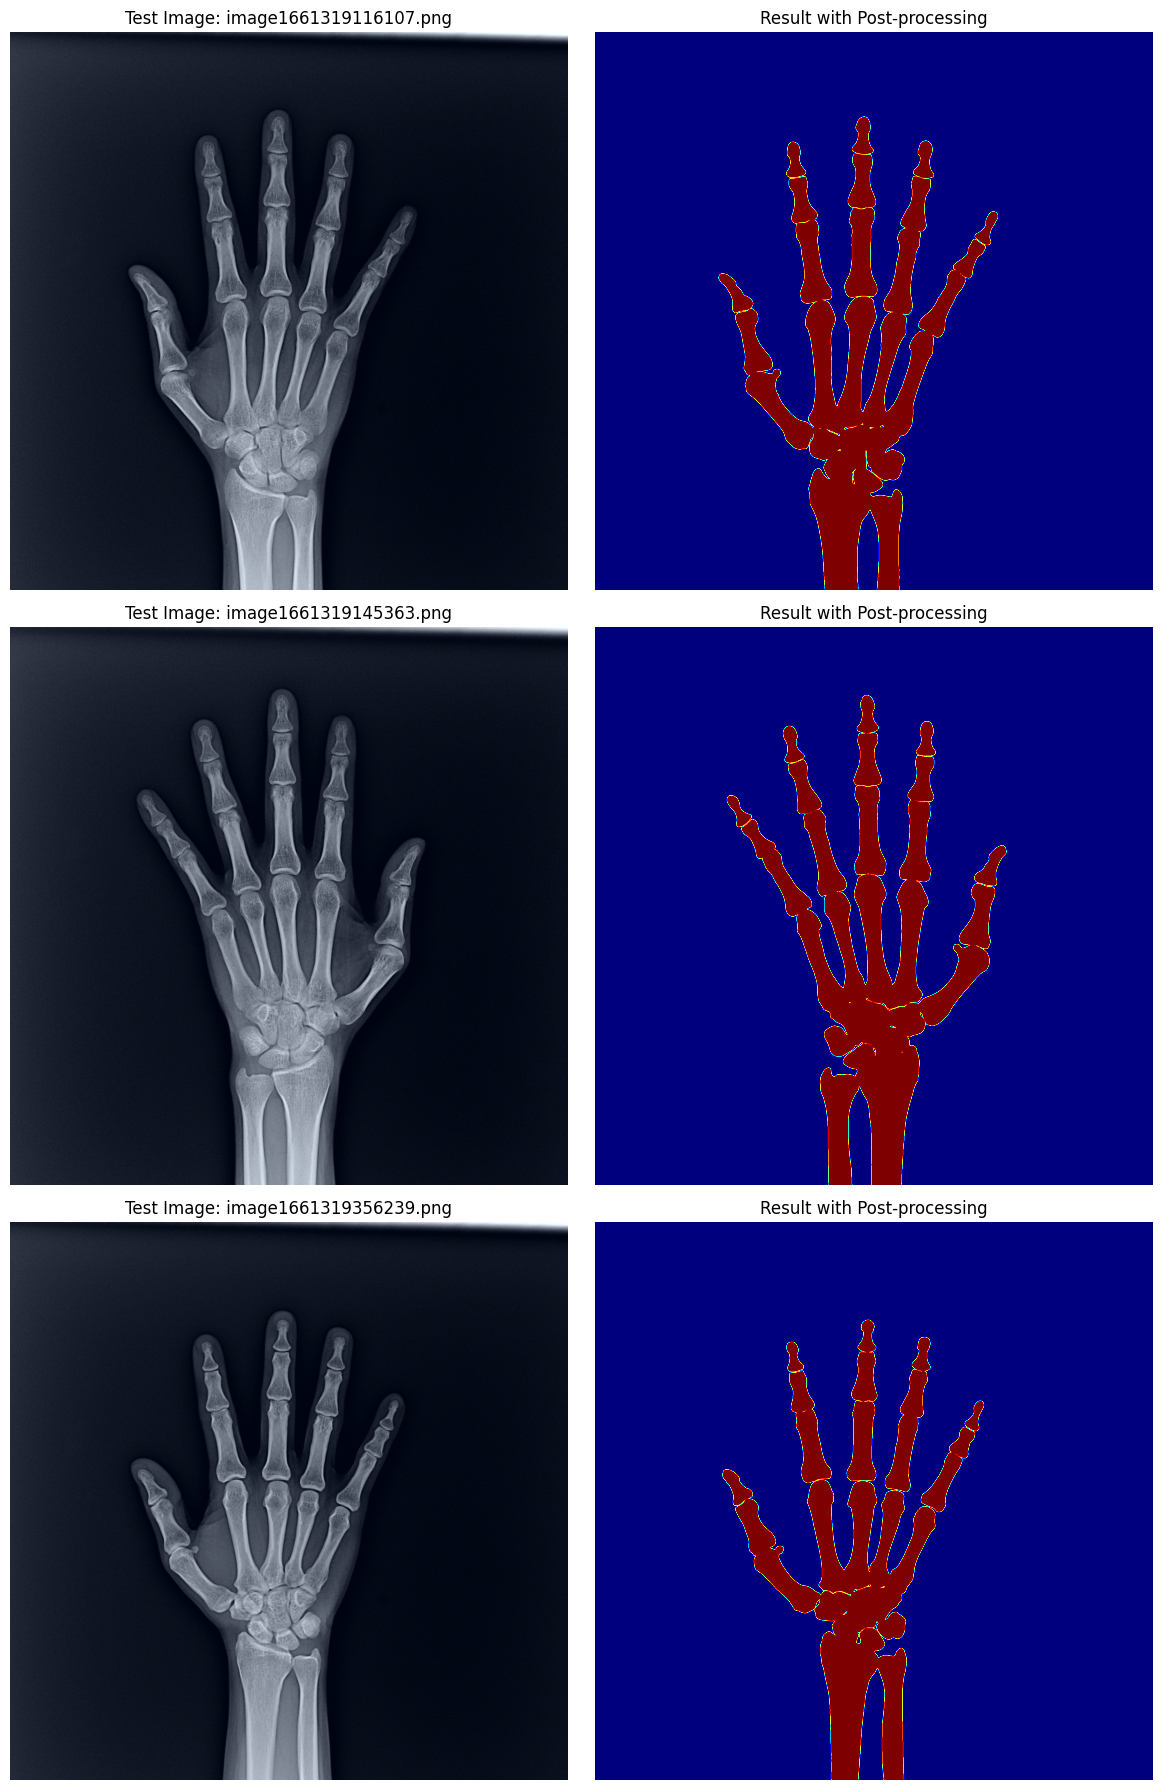

In [13]:
# =========================
# 6. Grid Inference Setup & TTA
# =========================
# ----------------------------------------------------------
# [Part 1] Inference Helper Functions
# ----------------------------------------------------------
# 1. Resize Prediction 함수 (Global Context - 위치 정보 파악용)
def predict_resize(model, image, size=1024, device='cuda'):
    """
    전체 이미지를 줄여서 예측 (숲을 봄: 손가락 번호 등 클래스 분류에 유리)
    """
    model.eval()
    c, h, w = image.shape
    
    # Downscale (Batch 차원 추가)
    img_resized = F.interpolate(
        image.unsqueeze(0), size=(size, size), 
        mode='bilinear', align_corners=False
    )
    
    with torch.no_grad():
        output = model(img_resized) # (1, 29, 1024, 1024)
        
    # Upscale to Original (Logits 상태로 복원)
    output = F.interpolate(
        output, size=(h, w), 
        mode='bilinear', align_corners=False
    )
    return output.squeeze(0)

# 2. 가우시안 가중치 생성 함수 (Sliding Window용)
def get_gaussian_2d(patch_size, sigma_scale=1/8, device='cuda'):
    tmp = torch.arange(patch_size, device=device)
    center = patch_size // 2
    sigma = patch_size * sigma_scale
    
    gaussian_1d = torch.exp(-(tmp - center)**2 / (2 * sigma**2))
    gaussian_2d = gaussian_1d.unsqueeze(1) * gaussian_1d.unsqueeze(0)
    gaussian_2d = gaussian_2d / gaussian_2d.max()
    return gaussian_2d

# 3. Sliding Window Prediction 함수 (Local Detail - 경계선 파악용)
def predict_sliding_window(model, image, window_size=1024, stride=512, num_classes=29, device='cuda'):
    """
    2048x2048 이미지를 1024x1024 윈도우로 50%씩 겹쳐가며 예측 (나무를 봄)
    """
    model.eval()
    _, h, w = image.shape
    
    output_map = torch.zeros((num_classes, h, w), device=device)
    count_map = torch.zeros((num_classes, h, w), device=device)
    gaussian_weight = get_gaussian_2d(window_size, device=device)
    
    steps_h = list(range(0, h - window_size + 1, stride))
    steps_w = list(range(0, w - window_size + 1, stride))
    if steps_h[-1] + window_size != h: steps_h.append(h - window_size)
    if steps_w[-1] + window_size != w: steps_w.append(w - window_size)
    
    with torch.no_grad():
        for y in steps_h:
            for x in steps_w:
                img_patch = image[:, y:y+window_size, x:x+window_size].unsqueeze(0)
                pred_patch = model(img_patch).squeeze(0)
                
                output_map[:, y:y+window_size, x:x+window_size] += pred_patch * gaussian_weight
                count_map[:, y:y+window_size, x:x+window_size] += gaussian_weight
                
    return output_map / (count_map + 1e-7)

# 4. Hybrid Prediction 함수
def predict_hybrid(model, image, device='cuda'):
    pred_global = predict_resize(model, image, size=1024, device=device)
    pred_local = predict_sliding_window(model, image, window_size=1024, stride=512, device=device)
    
    # [핵심 변경] Average 대신 Max를 사용!
    # Sliding Window가 찾은 디테일(뼈)을 Resize가 뭉개지 못하게 방어합니다.
    final_pred = torch.max(pred_global, pred_local)
    
    return final_pred

# 5. TTA 함수 (Hybrid 함수 호출로 변경)
def predict_with_tta(model, image, device='cuda'):
    # 원본 Hybrid 예측
    pred_origin = predict_hybrid(model, image, device=device)
    
    # 좌우 반전 Hybrid 예측
    image_flipped = torch.flip(image, dims=[-1])
    pred_flipped = predict_hybrid(model, image_flipped, device=device)
    
    # 반전 복구 및 평균
    pred_flipped_back = torch.flip(pred_flipped, dims=[-1])
    
    return (pred_origin + pred_flipped_back) / 2.0

# 6. Post-processing Function (접착제 & 청소)
def apply_post_processing(prob_map, threshold=0.3, kernel_size=11): # Threshold 0.35 -> 0.3, Kernel 7 -> 11
    """
    더 낮은 임계값과 더 큰 커널로 끊어진 부위를 강력하게 잇습니다.
    """
    num_classes, h, w = prob_map.shape
    final_mask = np.zeros((num_classes, h, w), dtype=np.uint8)
    
    # 커널 크기 키움 (7 -> 11)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    
    for c in range(num_classes):
        # (1) Thresholding (더 낮춤 0.3)
        # Max 앙상블을 썼기 때문에 확률값이 살아있을 가능성이 높지만, 
        # 확실하게 살리기 위해 0.3까지 낮춥니다.
        binary_mask = (prob_map[c] > threshold).astype(np.uint8)
        
        # (2) Morphology Closing (강력한 접착)
        binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
        
        # (3) LCC (노이즈 제거 - 필수)
        # Threshold를 낮춰서 생긴 자잘한 노이즈를 여기서 다 지워줍니다.
        num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)
        if num_labels > 1:
            largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
            binary_mask = (labels == largest_label).astype(np.uint8)
            
        final_mask[c] = binary_mask
    return final_mask


# ----------------------------------------------------------
# [Part 2] Dataset & Loader
# ----------------------------------------------------------
test_transform = A.Compose([
    A.Normalize(),
    ToTensorV2()
])

class XRayInferenceDataset(Dataset):
    def __init__(self, image_paths, transforms=None):
        self.image_paths = image_paths
        self.transforms = transforms
    def __len__(self): return len(self.image_paths)
    def __getitem__(self, item):
        image_path = self.image_paths[item]
        image_name = os.path.basename(image_path)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transforms:
            augmented = self.transforms(image=image)
            image = augmented['image']
        return image, image_name

# 경로 설정
test_search_path = os.path.join(CONFIG['ROOT_DIR'], 'test/DCM', '**', '*.png')
test_png_paths = sorted(glob.glob(test_search_path, recursive=True))
test_dataset = XRayInferenceDataset(test_png_paths, transforms=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

# ----------------------------------------------------------
# [Part 3] Sanity Check
# ----------------------------------------------------------
model.eval()
test_loader_iter = iter(test_loader)
fig, axes = plt.subplots(3, 2, figsize=(12, 18))

for i in range(3):
    try:
        image, image_name = next(test_loader_iter)
    except StopIteration:
        break

    image = image[0].cuda() # GPU 이동
    
    # 1. 모델 예측 (Hybrid + TTA)
    output = predict_with_tta(model, image)
    
    # 2. 확률값 변환 (Sigmoid)
    output_prob = torch.sigmoid(output).detach().cpu().numpy()
    
    # 3. [핵심] 후처리 적용 (Threshold 0.35, Kernel 7)
    # 끊어진 뼈가 잘 붙는지 확인하세요!
    post_processed_mask = apply_post_processing(output_prob, threshold=0.3, kernel_size=11)
    
    # 시각화용
    pred_mask = np.max(post_processed_mask, axis=0)
    img_vis = image.cpu().permute(1, 2, 0).numpy()
    img_vis = np.clip((img_vis * 0.229 + 0.485), 0, 1)
    
    axes[i, 0].imshow(img_vis)
    axes[i, 0].set_title(f"Test Image: {image_name[0]}")
    axes[i, 0].axis('off')
    axes[i, 1].imshow(pred_mask, cmap='jet')
    axes[i, 1].set_title("Result with Post-processing")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [14]:
# =========================
# 7. Inference Loop & Submission
# =========================
def encode_mask_to_rle(mask):
    pixels = mask.flatten() 
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

print(f"\n>>> Start Final Inference (Total {len(test_loader)} images)...")

# 저장된 Best Model 불러오기
if os.path.exists("best_model.pth"):
    model.load_state_dict(torch.load("best_model.pth"))
    print("🏆 Loaded Best Model from 'best_model.pth'")
else:
    print("⚠️ Warning: 'best_model.pth' not found. Using current model weights.")

model.eval()
rles = []
filename_and_class = []

# 진행률 표시 (tqdm)
for image, image_name in tqdm(test_loader):
    image = image[0].cuda()
    
    output = predict_with_tta(model, image)
    output_prob = torch.sigmoid(output).detach().cpu().numpy()
    
    # [핵심] 변경된 파라미터 적용
    final_mask = apply_post_processing(output_prob, threshold=0.3, kernel_size=11)
    
    image_name = image_name[0]
    for c, segm in enumerate(final_mask):
        rle = encode_mask_to_rle(segm)
        rles.append(rle)
        filename_and_class.append(f"{CLASSES[c]}_{image_name}")



>>> Start Final Inference (Total 288 images)...
🏆 Loaded Best Model from 'best_model.pth'


100%|██████████| 288/288 [14:56<00:00,  3.11s/it]


In [15]:
# =========================
# 8. Save CSV
# =========================
print("\n>>> Creating submission.csv...")

# "ClassName_ImageName" 형식을 분리
classes, filename = zip(*[x.split("_", 1) for x in filename_and_class])

# DataFrame 생성
df = pd.DataFrame({
    "image_name": filename,
    "class": classes,
    "rle": rles
})

# 저장
save_name = "U-Net++ + EfficientNet-B4_slide.csv"
df.to_csv(save_name, index=False)

print(f"\n✅ Final Submission Saved: {save_name}")
print(f"   Total Rows: {len(df)}")



>>> Creating submission.csv...

✅ Final Submission Saved: U-Net++ + EfficientNet-B4_slide.csv
   Total Rows: 8352
